# __Puffins__

## NB 02 - Comparing regression methods and implementations

In NB01, we saw how we can use __puffins__ to flexibly model highly complex and non-sinusoidal periodic signals in time series data using a regression model with a "Fourier" feature embedding and weighting. 

In this notebook, we're going to look at how the model outputs change depending on what regression method we use. We're going to do this on two test cases - specifically, i) with the full U Gru data set of 15000 data points, and ii) on a random subset of 20% of the data. 

At the end, we'll also compare different numerical implementations for solving the equations.

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

from pythia.timeseries.lombscargle import LS_periodogram
from puffins.utils import construct_design_matrix
from puffins.basis_functions import basis_constant, basis_linear, basis_polynomial
from puffins.solver import solve
from puffins.weight_functions import matern32
from puffins.timeseries import TimeSeries,LinearModel


np.random.seed(8675309) # MAGIC to enforce reproducibility
RCOND = 1e-14 # MAGIC input to `np.linalg.lstsq()`
plotnum=1

In [3]:
# Load up the data
time, flux = np.loadtxt('../data/ugru.dat').T
N = len(time)
period = 1.88045
K = 300

Let's take a look at the raw data

In [4]:
data_full = TimeSeries(time, flux)
print(data_full)

TimeSeries with properties:
Time base of observations: 24.3899784208229
Number of data points: 15000
Median time step: 0.001388874274198315
Number of models computed: 0


In [107]:
## Select a random subset of 20% of the data
idx = np.random.randint(0, N-1, int(N*0.1))
time_subset = time[idx]
flux_subset = flux[idx]
data_subset = TimeSeries(time_subset, flux_subset)
print(data_subset)

TimeSeries with properties:
Time base of observations: 24.38025643547917
Number of data points: 1500
Median time step: 0.009722168347707338
Number of models computed: 0


Okay, so, we now have two data sets - and we're going to make a "Weighted Least Squares", "Ridge" and "Feature Weighted" regression model for each.

Each model will have the same basis functions that lead the design matrix (an offset and linear trend) and use the Fourier feature embedding with the same number of harmonics (K=300). Furthermore, none of the models will consider the uncertainties on the observations.

To make things easier, we're going to instantiate and train all of the models and add them to their respective data

First, for the full dataset.

In [108]:
wls_full = LinearModel(data_full, basis_functions=[basis_constant, basis_linear,], feature_embedding='fourier', 
                   feature_weighting_function=None, feature_width=None,
                   method='wls', period=period, n_harmonics=K, W=None)

ridge_full = LinearModel(data_full, basis_functions=[basis_constant, ], feature_embedding='fourier', 
                   feature_weighting_function=None, feature_width=None, alpha=5.0,
                   method='ridge', period=period, n_harmonics=K, W=None)

fw_full = LinearModel(data_full, basis_functions=[basis_constant,], feature_embedding='fourier', 
                   feature_weighting_function=matern32, feature_width=0.025,
                   method='fw', period=period, n_harmonics=K, W=None)


In [109]:
wls_full.set_X_train()
wls_full.train()

ridge_full.set_X_train()
ridge_full.train()

fw_full.set_X_train()
fw_full.train()

FW not applied
FW not applied
FW applied
S= 0.025


In [110]:
data_full.add_model(wls_full)
data_full.add_model(ridge_full)
data_full.add_model(fw_full)

Now that we've computed all the models for the different datasets, we're going to start comparing them.
First, we'll take a look at the model fits by eye. 
Then, we'll consider the scatter in the residuals, and finally we'll compare the values of the regression coefficients!

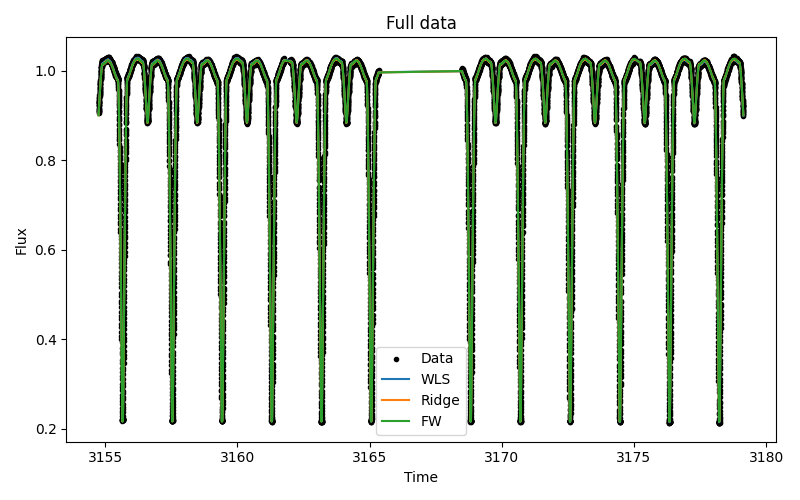

In [111]:
plotnum += 1
fig_full, ax_full = plt.subplots(1, 1, figsize=(8, 5), num=plotnum)
ax_full.plot(data_full.x, data_full.y, 'k.', label='Data')
ax_full.plot(data_full.x, data_full.models['wls'].predict(data_full.x)[1], label='WLS')
ax_full.plot(data_full.x, data_full.models['ridge'].predict(data_full.x)[1], label='Ridge')
ax_full.plot(data_full.x, data_full.models['fw'].predict(data_full.x)[1], label='FW')
ax_full.legend()
ax_full.set_xlabel('Time')
ax_full.set_ylabel('Flux')
ax_full.set_title('Full data')
fig_full.tight_layout()
plt.show()

Okay, by eye, they all look pretty good. But there will be some differences. Let's take a closer look at the distribution of residuals from the different methods. 

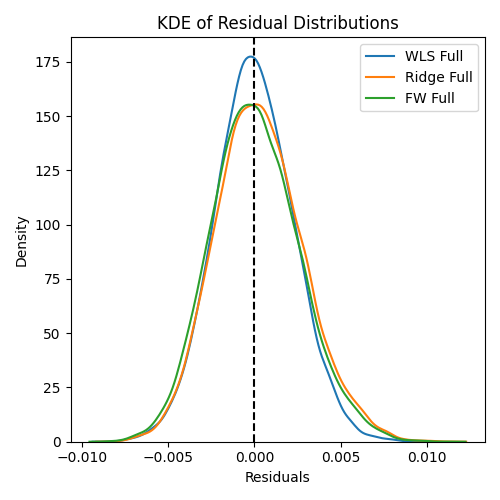

In [112]:
import seaborn as sns

# Plot KDE of residual distributions
plotnum += 1
fig_residuals, ax_residuals = plt.subplots(1, 1, figsize=(5, 5), num=plotnum)

sns.kdeplot(data_full.residuals['wls'], ax=ax_residuals, label='WLS Full')
sns.kdeplot(data_full.residuals['ridge'], ax=ax_residuals, label='Ridge Full')
sns.kdeplot(data_full.residuals['fw'], ax=ax_residuals, label='FW Full')

# sns.kdeplot(residuals_wls_subset, ax=ax_residuals, label='WLS Subset')
# sns.kdeplot(residuals_ridge_subset, ax=ax_residuals, label='Ridge Subset')
# sns.kdeplot(residuals_fw_subset, ax=ax_residuals, label='FW Subset')
ax_residuals.axvline(0, color='k', linestyle='--')
ax_residuals.legend()
ax_residuals.set_xlabel('Residuals')
ax_residuals.set_ylabel('Density')
ax_residuals.set_title('KDE of Residual Distributions')
fig_residuals.tight_layout()
plt.show()

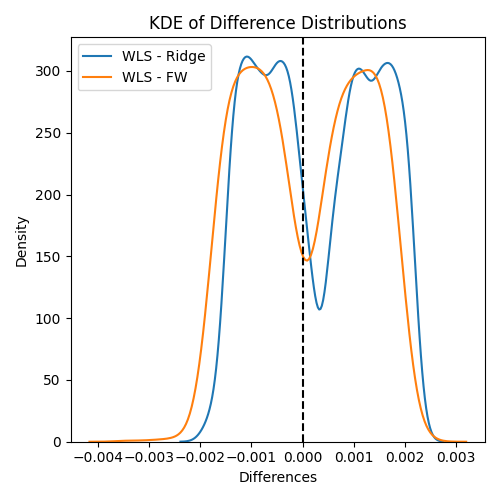

In [113]:
import seaborn as sns

# Plot KDE of residual distributions
plotnum += 1
fig_diffs, ax_diffs = plt.subplots(1, 1, figsize=(5, 5), num=plotnum)

sns.kdeplot(data_full.trained_models['wls']-data_full.trained_models['ridge'], ax=ax_diffs, label='WLS - Ridge')
sns.kdeplot(data_full.trained_models['wls']-data_full.trained_models['fw'], ax=ax_diffs, label='WLS - FW')

ax_diffs.axvline(0, color='k', linestyle='--')
ax_diffs.legend()
ax_diffs.set_xlabel('Differences')
ax_diffs.set_ylabel('Density')
ax_diffs.set_title('KDE of Difference Distributions')
fig_diffs.tight_layout()
plt.show()

Add commentary

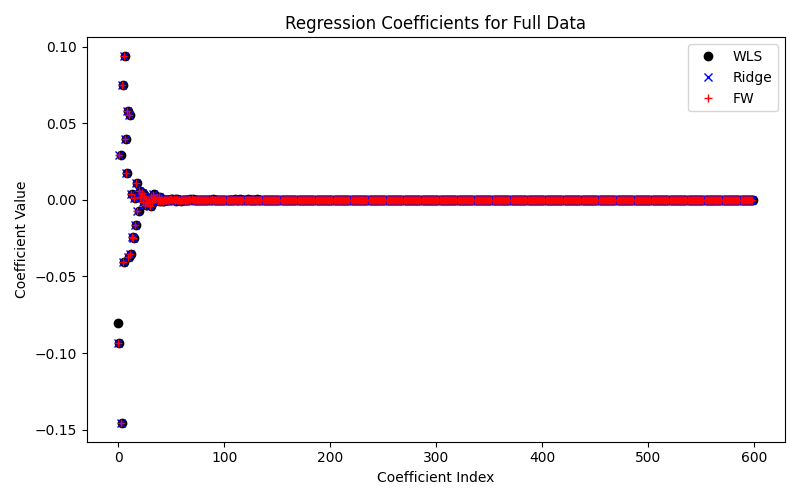

In [114]:
# Extract regression coefficients
coeffs_wls = wls_full.coefficients
coeffs_ridge = ridge_full.coefficients
coeffs_fw = fw_full.coefficients

# Plot the coefficients
plotnum += 1
fig_coeffs, ax_coeffs = plt.subplots(1, 1, figsize=(8, 5), num=plotnum)
ax_coeffs.plot(coeffs_wls[2:], 'ko', label='WLS')
ax_coeffs.plot(coeffs_ridge[2:], 'bx', label='Ridge')
ax_coeffs.plot(coeffs_fw[2:], 'r+', label='FW')
ax_coeffs.legend()
ax_coeffs.set_xlabel('Coefficient Index')
ax_coeffs.set_ylabel('Coefficient Value')
ax_coeffs.set_title('Regression Coefficients for Full Data')
fig_coeffs.tight_layout()
plt.show()

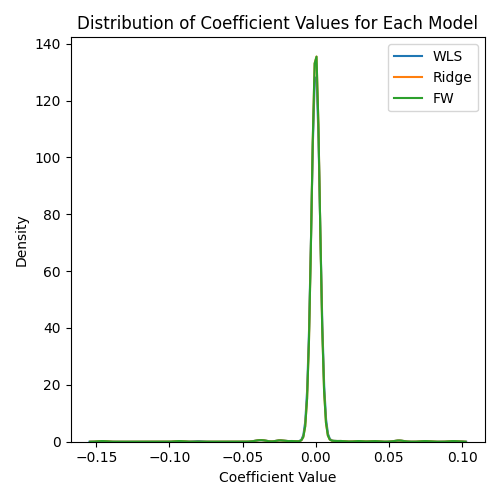

In [115]:
# Plot the distribution of coefficient values for each model
plotnum += 1
fig_coeff_dist, ax_coeff_dist = plt.subplots(1, 1, figsize=(5, 5), num=plotnum)

sns.kdeplot(coeffs_wls[2:], ax=ax_coeff_dist, label='WLS')
sns.kdeplot(coeffs_ridge[2:], ax=ax_coeff_dist, label='Ridge')
sns.kdeplot(coeffs_fw[2:], ax=ax_coeff_dist, label='FW')

ax_coeff_dist.legend()
ax_coeff_dist.set_xlabel('Coefficient Value')
ax_coeff_dist.set_ylabel('Density')
ax_coeff_dist.set_title('Distribution of Coefficient Values for Each Model')
fig_coeff_dist.tight_layout()
plt.show()

## Subset
Now let's do the same analysis for the smaller subset of the data!

In [116]:
wls_subset = LinearModel(data_subset, basis_functions=[basis_constant, basis_linear,], feature_embedding='fourier', 
                   feature_weighting_function=None, feature_width=None,
                   method='wls', period=period, n_harmonics=K, W=None)

ridge_subset = LinearModel(data_subset, basis_functions=[basis_constant, ], feature_embedding='fourier', 
                   feature_weighting_function=None, feature_width=None, alpha=0.1,
                   method='ridge', period=period, n_harmonics=K, W=None)

fw_subset = LinearModel(data_subset, basis_functions=[basis_constant, ], feature_embedding='fourier', 
                   feature_weighting_function=matern32, feature_width=0.015,
                   method='fw', period=period, n_harmonics=K, W=None)


In [117]:
wls_subset.set_X_train()
wls_subset.train()

ridge_subset.set_X_train()
ridge_subset.train()

fw_subset.set_X_train()
fw_subset.train()

FW not applied
FW not applied
FW applied
S= 0.015


In [118]:
data_subset.add_model(wls_subset)
data_subset.add_model(ridge_subset)
data_subset.add_model(fw_subset)

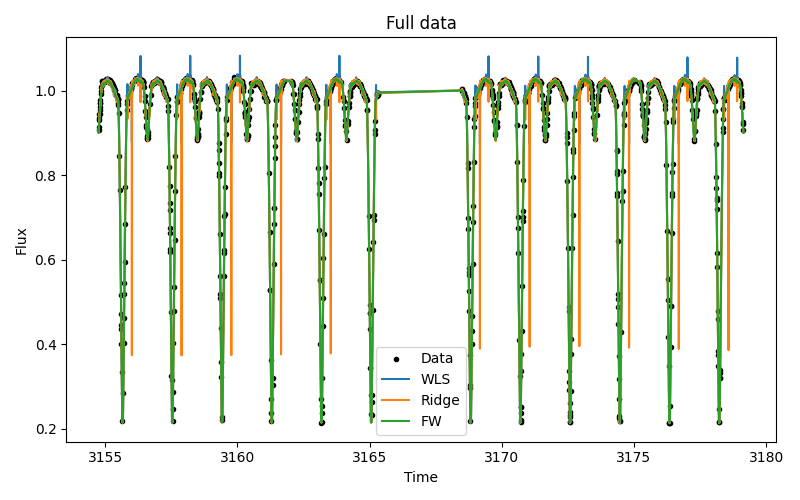

In [119]:
plotnum += 1
fig_sub, ax_sub = plt.subplots(1, 1, figsize=(8, 5), num=plotnum)
ax_sub.plot(data_subset.x, data_subset.y, 'k.', label='Data')
ax_sub.plot(data_full.x, data_subset.models['wls'].predict(data_full.x)[1], label='WLS')
ax_sub.plot(data_full.x, data_subset.models['ridge'].predict(data_full.x)[1], label='Ridge')
ax_sub.plot(data_full.x, data_subset.models['fw'].predict(data_full.x)[1], label='FW')
ax_sub.legend()
ax_sub.set_xlabel('Time')
ax_sub.set_ylabel('Flux')
ax_sub.set_title('Full data')
fig_sub.tight_layout()
plt.show()

We can already see that when we're only using 10% of the data, both the ridge and weight least squares regression don't train a well behaved model!
On the other hand, however, we see that the Feature weighted regression does. 

To formalise this a bit more, let's look at the residuals and coefficients like we did for the model of the full data set.

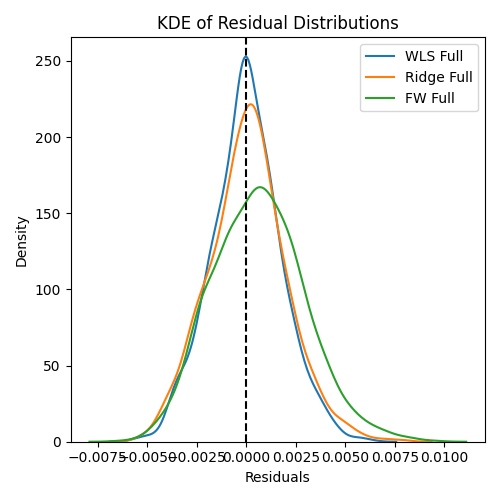

In [122]:
# Plot KDE of residual distributions
plotnum += 1
fig_residuals_subset, ax_residuals_subset = plt.subplots(1, 1, figsize=(5, 5), num=plotnum)

sns.kdeplot(data_subset.residuals['wls'], ax=ax_residuals_subset, label='WLS Full')
sns.kdeplot(data_subset.residuals['ridge'], ax=ax_residuals_subset, label='Ridge Full')
sns.kdeplot(data_subset.residuals['fw'], ax=ax_residuals_subset, label='FW Full')

ax_residuals_subset.axvline(0, color='k', linestyle='--')
ax_residuals_subset.legend()
ax_residuals_subset.set_xlabel('Residuals')
ax_residuals_subset.set_ylabel('Density')
ax_residuals_subset.set_title('KDE of Residual Distributions')
fig_residuals_subset.tight_layout()
plt.show()

What's going on here? We can see that the distribution of residuals is fairly well behaved, despite seeing the huge deviations in the plot itself. This is caused by the model misbehaving where there are no observed data points! If we were to plot the distribution of residuals with respect to the full dataset, we'd see a much less well behaved distribution. Let's just have a look at that below. 

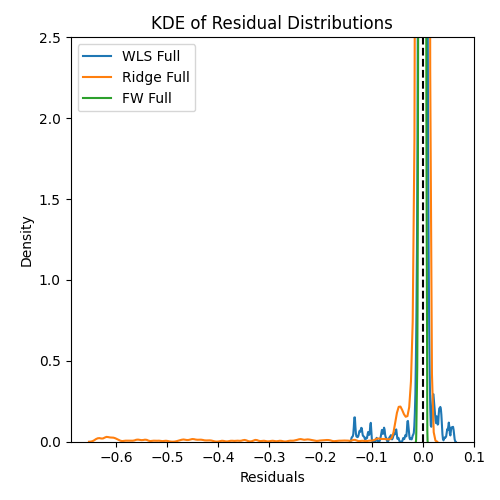

In [123]:
# Plot KDE of residual distributions
plotnum += 1
fig_residuals_, ax_residuals_ = plt.subplots(1, 1, figsize=(5, 5), num=plotnum)

sns.kdeplot(data_subset.models['wls'].predict(data_full.x)[1] - data_full.y, ax=ax_residuals_, label='WLS Full')
sns.kdeplot(data_subset.models['ridge'].predict(data_full.x)[1] - data_full.y, ax=ax_residuals_, label='Ridge Full')
sns.kdeplot(data_subset.models['fw'].predict(data_full.x)[1] - data_full.y, ax=ax_residuals_, label='FW Full')

ax_residuals_.axvline(0, color='k', linestyle='--')
ax_residuals_.legend()
ax_residuals_.set_xlabel('Residuals')
ax_residuals_.set_ylabel('Density')
ax_residuals_.set_title('KDE of Residual Distributions')
fig_residuals_.tight_layout()
ax_residuals_.set_ylim(0, 2.5)
plt.show()

Here, we can see that when comapred to the full dataset, the WLS and Ridge models trained on only 10% of data have much higher residuals in places. Again, this is because the model is behaving poorly on data that it hasn't seen with such a high flexibility (i.e., lots of features).

Now that we know that the WLS and Ridge models do worse on less data, that raises a number of questions -

 - i) How much data is required for the models to perform equally as good as the case of 15000 data points? 
 - ii) How does model performance trend as a function of training N / p?
 - iii) How stable are __&beta;__ values as a function of N / p?
 - iv) What is the role of the smoothing parameter S?

These are crucial questions to answer to understand the model behaviour and application, and so, we'll dedicate an entire notebook to answering each question. However, we first want to establish a way of determining uncertainties for the features and for empirically determining the value of penalty/smoothing terms. These will be the focus of our next two notebooks before returning to answer these four questions above.

In [128]:
# # Extract coefficients for the fw model for both full and subset data
# coeffs_fw_full = fw_full.coefficients
# coeffs_fw_subset = fw_subset.coefficients

# # Calculate the difference in coefficients
# coeffs_diff = abs(coeffs_fw_full - coeffs_fw_subset)

# # Plot the difference in coefficients
# plotnum += 1
# fig_coeff_diff, ax_coeff_diff = plt.subplots(1, 1, figsize=(8, 5), num=plotnum)
# ax_coeff_diff.plot(100*coeffs_diff[2:52]/coeffs_fw_full[2:52], 'ko', label='FW Coefficients Difference')
# ax_coeff_diff.legend()
# ax_coeff_diff.set_xlabel('Coefficient Index')
# ax_coeff_diff.set_ylabel('Per-cent Coefficient Difference')
# ax_coeff_diff.set_title('Difference in FW Model Coefficients (Full Data - Subset Data)')
# fig_coeff_diff.tight_layout()
# plt.show()

## Note on numerical implementation

Numerical solvers for matrix operations are notoriously finicky when dealing with matrix inversions. For this reason, it is often agreed that you __should not__ directly calculate the inversion of a matrix (or matrix operation) and should instead use a routine that avoids explicitly calculating a matrix-inverse where possible.

Below, we look at the different ways of implementing the ordinary least squares.

In [129]:
def ols_solve(X,y, weights=None):
    n, p = X.shape
    if weights is None:
        weights = np.ones(n)
    XTCinv = X.T * weights
    
    return np.linalg.solve( XTCinv @ X, XTCinv @ y)


def ols_lstsq(X, y, weights=None, rcond=1e-14):
    n, p = X.shape
    if weights is None:
        weights = np.ones(n)
    XTCinv = X.T * weights
    return np.linalg.lstsq(XTCinv @ X, XTCinv @ y, rcond=rcond)[0]


def ols_direct(X, y, weights=None):
    n, p = X.shape
    if weights is None:
        weights = np.ones(n)
    XTCinv = X.T * weights
    return np.linalg.inv(XTCinv @ X) @ XTCinv @ y

In [136]:
Xfull = data_full.models['wls'].X_train
yfull = data_full.y
Xsubset = data_subset.models['wls'].X_train
ysubset = data_subset.y

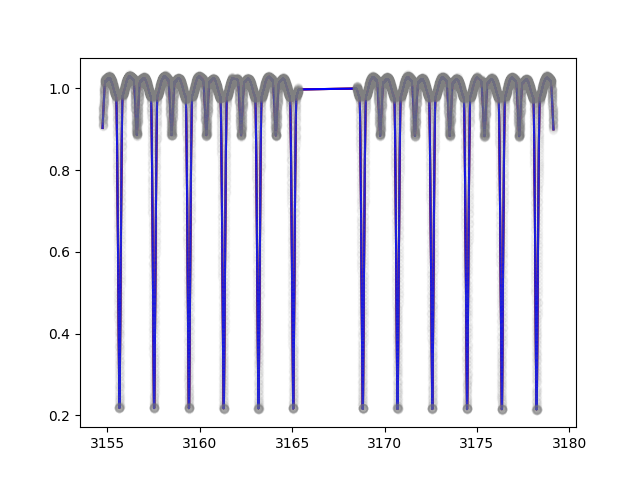

In [137]:
betas_solve_full = ols_solve(Xfull, yfull)
betas_lstsq_full = ols_lstsq(Xfull, yfull)
betas_direct_full = ols_direct(Xfull, yfull)

syn_solve_full = Xfull @ betas_solve_full
syn_lstsq_full = Xfull @ betas_lstsq_full
syn_dir_full = Xfull @ betas_direct_full

plotnum += 1
fig_, ax_ = plt.subplots(num=plotnum)
ax_.plot(data_full.x, syn_lstsq_full, 'k-')
ax_.plot(data_full.x, syn_lstsq_full, 'r-')
ax_.plot(data_full.x, syn_dir_full, 'b-')
ax_.plot(data_full.x, yfull, 'o', color='grey', alpha=0.05)

plt.show()

As we can see, in the case where N (15000) >>>>>>> p (602), the matrix inversions are all handled well and the models all look the same (and are the same to our RCOND value)

Let's see if the same holds for our models where N (1500) > p (602)

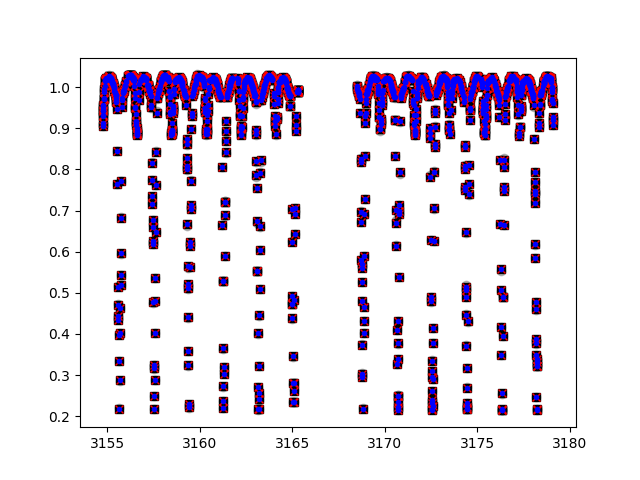

In [143]:
betas_solve_subset = ols_solve(Xsubset, ysubset)
betas_lstsq_subset = ols_lstsq(Xsubset, ysubset)
betas_direct_subset = ols_direct(Xsubset, ysubset)

syn_solve_subset = Xsubset @ betas_solve_subset
syn_lstsq_subset = Xsubset @ betas_lstsq_subset
syn_dir_subset = Xsubset @ betas_direct_subset

plotnum += 1
fig_, ax_ = plt.subplots(num=plotnum)
ax_.plot(data_subset.x, ysubset, 'o', color='grey', alpha=0.5)
ax_.plot(data_subset.x, syn_lstsq_subset, 'ks')
ax_.plot(data_subset.x, syn_lstsq_subset, 'rx')
ax_.plot(data_subset.x, syn_dir_subset, 'b.')

plt.show()

If you look closely, the models all agree (equally poorly since they don't actually hit the data points very well). So in this case, the solvers all behave the same. However, when we get closer and closer to N = p or N < p, the choice of routine actually matters. So, in this code we use np.linalg.lstsq to avoid explicitly calculating any matrix inverse.